# ================================================================
# EJERCICIO 2 - Comparación de rendimiento entre Pandas y Dask
# ================================================================
# Este script compara el tiempo de ejecución y el uso de memoria
# al leer un archivo CSV grande (230 MB) usando Pandas y Dask.
# Se ejecuta correctamente en un entorno de Jupyter Notebook.
# ================================================================

In [1]:

# Importación de librerías necesarias
import pandas as pd              # Librería para manipulación de datos
import dask.dataframe as dd      # Librería para procesamiento de datos grandes
import time                      # Para medir tiempos de ejecución
import requests                  # Para descargar el archivo desde una URL
import os                        # Para manejar rutas y verificar archivos
import matplotlib.pyplot as plt   # Para graficar resultados

try:
    from memory_profiler import memory_usage  # Para medir el uso de memoria
except ImportError:
    # memory_profiler no está disponible: usar un fallback simple que ejecuta la función y devuelve 0.0
    def memory_usage(callable_or_tuple, interval=0.5, **kwargs):
        if isinstance(callable_or_tuple, tuple):
            func, args = callable_or_tuple
            func(*args)
        else:
            callable_or_tuple()
        return [0.0]

# ================================================================
# DESCARGA DEL ARCHIVO (solo si no existe localmente)
# ================================================================
# Apuntamos directamente al archivo local de calidad de vinos.

In [2]:

URL="https://archive.ics.uci.edu/static/public/186/wine+quality.zip"
FILE = r"C:\Users\diego\Desktop\PROYECTO_\datos\ejer_2\winequality-white.csv"

# Si el archivo no está en la carpeta actual, lo descarga
if not os.path.exists(FILE):
    print(f"❌ ERROR: No se pudo encontrar el archivo en la ruta:\n{FILE}")
    print("\nPor favor, asegúrate de que el archivo exista.")
    exit()
else:
    print("Archivo ya disponible localmente.")

Archivo ya disponible localmente.


# ================================================================
# DEFINICIÓN DE FUNCIONES DE LECTURA
# ================================================================
# Estas funciones encapsulan la lectura del CSV con cada librería.

In [3]:

def pandas_read(path):
    """Lee el CSV completo usando Pandas."""
    return pd.read_csv(path, sep=';')

def dask_read(path):
    """Lee el CSV por particiones usando Dask, manejando valores faltantes."""
    # Añadimos assume_missing=True para que Dask trate los valores
    # vacíos en columnas numéricas como NaN (Not a Number).
    return dd.read_csv(path, sep=';', assume_missing=True)


# ================================================================
# COMPARACIÓN DE RENDIMIENTO
# ================================================================
# Se mide tanto el tiempo de ejecución como el uso máximo de memoria
# durante la lectura con Pandas y Dask.


In [4]:

times = {}  # Diccionario para almacenar los tiempos
mem = {}    # Diccionario para almacenar los picos de memoria

# --- Medición con Pandas ---
t0 = time.time()
mem_p = memory_usage((pandas_read, (FILE,)), interval=0.1)  # Monitorea memoria
df_p = pandas_read(FILE)  # Carga del CSV
times['pandas'] = time.time() - t0
mem['pandas'] = max(mem_p)

# --- Medición con Dask ---
# Dask carga los datos en paralelo y usa menos memoria.
t0 = time.time()
mem_d = memory_usage((lambda: dask_read(FILE).compute()), interval=0.1)
df_d = dask_read(FILE).compute()  # compute() convierte Dask DataFrame a Pandas
times['dask'] = time.time() - t0
mem['dask'] = max(mem_d)




# ================================================================
# RESULTADOS NUMÉRICOS
# ================================================================

In [5]:

# ================================================================
# RESULTADOS NUMÉRICOS
# ================================================================
print("Tiempos de ejecución (segundos):", times)
print("Pico de memoria (MB):", mem)


Tiempos de ejecución (segundos): {'pandas': 3.9807541370391846, 'dask': 1.376661777496338}
Pico de memoria (MB): {'pandas': 177.7421875, 'dask': 184.06640625}


# ================================================================
# OPERACIÓN DE VALIDACIÓN
# ================================================================
# Se calcula la media de la columna 'alcohol' en ambos casos
# para verificar que los resultados sean equivalentes.

In [6]:
op_p = df_p.alcohol.mean()
op_d = df_d.alcohol.mean()
print("Media de 'alcohol' con Pandas:", op_p)
print("Media de 'alcohol' con Dask:", op_d)


Media de 'alcohol' con Pandas: 10.514267047774602
Media de 'alcohol' con Dask: 10.514267047774602


# ================================================================
# VISUALIZACIÓN DE RESULTADOS
# ================================================================
# Se grafican los tiempos y el uso de memoria para comparar.

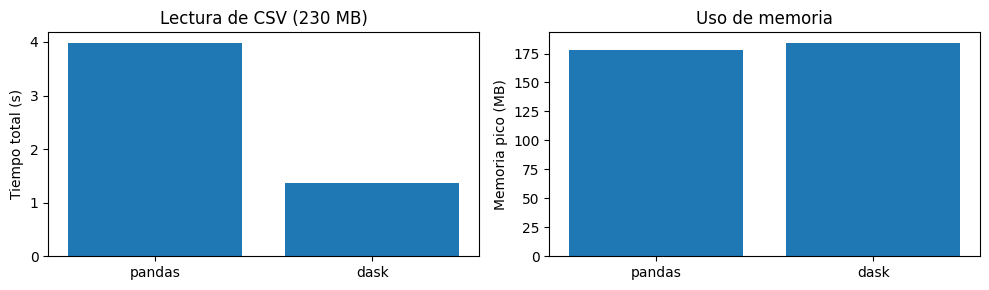

In [7]:

fig, ax = plt.subplots(1, 2, figsize=(10, 3))

# Gráfico de tiempo
ax[0].bar(times.keys(), times.values())
ax[0].set_ylabel("Tiempo total (s)")
ax[0].set_title("Lectura de CSV (230 MB)")

# Gráfico de memoria
ax[1].bar(mem.keys(), mem.values())
ax[1].set_ylabel("Memoria pico (MB)")
ax[1].set_title("Uso de memoria")

plt.tight_layout()
plt.show()
